# 오피지지 인턴 과정

오피지지 데이터 분석가 과정 교육을 수료하고 우수 교육생으로 한 달간 인턴 생활을 하게 되었습니다.

회사의 실무를 보면서 개인적으로 진행했던 과정에 대해 정리하고자 합니다.

본 내용들은 실제 인턴 생활에서 맡았던 업무와 관련 있다고 생각한 부분을 개인적으로 진행한 것 입니다.

실제 맡은 업무와는 상이할 수 있으니 참고 바랍니다.

## 미니맵 챔피언 인식

여기서는 `yolov5` 모델을 이용해서 리그 오브 레전드 게임 영상에서 미니맵의 챔피언을 인식해보겠습니다.

모델의 성능은 고려하지 않고 전체 과정을 간단하게 살펴보았습니다.

본 코드는 코랩으로 진행하였으며 혹시 직접 해보고 싶다면 경로 등에 유의하세요.

(특히나 저 같은 경우는 디렉토리를 변경하거나 절대경로를 많이 사용했습니다.)

### 1.환경 설정

In [1]:
# drive mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


- 드라이브 마운트

In [2]:
import os
import glob
import zipfile

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import requests

import warnings
warnings.filterwarnings("ignore")

In [3]:
# change directory
%cd /content

# yolov5 git clone
!git clone https://github.com/ultralytics/yolov5.git

/content
Cloning into 'yolov5'...
remote: Enumerating objects: 10081, done.
remote: Total 10081 (delta 0), reused 0 (delta 0), pack-reused 10081
Receiving objects: 100% (10081/10081), 10.40 MiB | 24.54 MiB/s, done.
Resolving deltas: 100% (6990/6990), done.


In [4]:
# package for yolov5
%cd /content/yolov5/
!pip install -r requirements.txt

/content/yolov5
     |████████████████████████████████| 596 kB 5.4 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


- yolov5 git을 클론하고 필요한 패키지 등을 설치합니다.

In [5]:
# create folder 
%cd /content/yolov5/
folder_lst = ["lol/images", "lol/labels", "lol/origin/crop"]

for folder in folder_lst:
    if not os.path.isdir(folder):
        os.makedirs(folder)

del folder_lst

/content/yolov5


- 저는 yolov5 폴더 밑에 하위 폴더를 생성해두었습니다.


- 추후 학습에 사용할 이미지 파일을 넣을 것입니다.

In [6]:
# image, labels 압축 해제
!unzip -uq '/content/drive/MyDrive/yolo_lol/images.zip' -d "/content/yolov5/lol/images"
!unzip -uq '/content/drive/MyDrive/yolo_lol/labels.zip' -d "/content/yolov5/lol/labels"

- 저는 미리 이미지, 라벨링 파일을 드라이브에 업로드 해두었습니다.


- 제 드라이브에 있는 zip파일을 앞서 만들 폴더에 압축해제 하였습니다.


- 이미지, 라벨링 파일 만드는 방법은 아래를 참고해주세요.

### 2.동영상 로드 및 편집

![](https://github.com/Romg2/Romg2.github.io/blob/master/_posts/OPGG_Part_time/2021-11-30-01/replay.PNG?raw=true)

- 저는 저의 게임 리플레이 영상(약5초)를 my_replay로 저장해두었습니다.


- 오른쪽 아래에 미니맵에 챔피언 초상화들이 확인됩니다.


- 이 챔피언들을 인식해보겠습니다.

In [7]:
# 동영상에서 이미지 추출
vidcap = cv2.VideoCapture('/content/drive/MyDrive/yolo_lol/my_replay.mp4')

count = 0

while vidcap.isOpened():
    ret, image = vidcap.read()
    
    # 캡쳐된 이미지를 저장하는 함수
    try:
        cv2.imwrite(f"./lol/origin/frame_{str(count).zfill(3)}.jpg", image)
        print(f'Saved frame_{str(count).zfill(3)}.jpg')
    except:
        print("End Save image")
        break
    if count == 59:
        break
    count += 1
    
# 메모리 해제
vidcap.release()

Saved frame_000.jpg
Saved frame_001.jpg
Saved frame_002.jpg
Saved frame_003.jpg
Saved frame_004.jpg
Saved frame_005.jpg
Saved frame_006.jpg
Saved frame_007.jpg
Saved frame_008.jpg
Saved frame_009.jpg
Saved frame_010.jpg
Saved frame_011.jpg
Saved frame_012.jpg
Saved frame_013.jpg
Saved frame_014.jpg
Saved frame_015.jpg
Saved frame_016.jpg
Saved frame_017.jpg
Saved frame_018.jpg
Saved frame_019.jpg
Saved frame_020.jpg
Saved frame_021.jpg
Saved frame_022.jpg
Saved frame_023.jpg
Saved frame_024.jpg
Saved frame_025.jpg
Saved frame_026.jpg
Saved frame_027.jpg
Saved frame_028.jpg
Saved frame_029.jpg
Saved frame_030.jpg
Saved frame_031.jpg
Saved frame_032.jpg
Saved frame_033.jpg
Saved frame_034.jpg
Saved frame_035.jpg
Saved frame_036.jpg
Saved frame_037.jpg
Saved frame_038.jpg
Saved frame_039.jpg
Saved frame_040.jpg
Saved frame_041.jpg
Saved frame_042.jpg
Saved frame_043.jpg
Saved frame_044.jpg
Saved frame_045.jpg
Saved frame_046.jpg
Saved frame_047.jpg
Saved frame_048.jpg
Saved frame_049.jpg


- 우선 영상을 프레임 단위의 이미지로 저장하여야 합니다.


- 60fps로 5 x 60 = 300 이미지 중 60장만 저장해두겠습니다.


- 저는 이미지 파일들을 따로 저장하고 추후 이 코드는 실행하지 않았습니다.

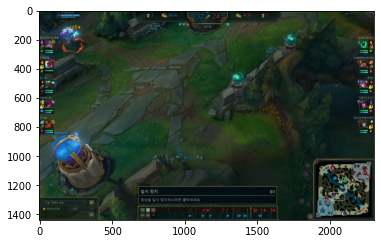

In [8]:
# 샘플로 1개 이미지 가져오기
img_basic = cv2.imread('./lol/origin/frame_000.jpg', cv2.IMREAD_COLOR)

plt.imshow(cv2.cvtColor(img_basic, cv2.COLOR_BGR2RGB))
plt.show()

- 프레임 단위로 저장된 이미지 중 1개를 불러왔습니다.


- 잘 불러와지는 것이 확인 되네요.

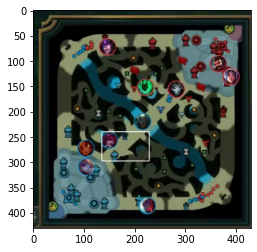

In [9]:
# 미니맵 자르기
img = img_basic[1010:,1874:,:]
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

- 여기선 수기로 잘라보면서 미니맵을 추출하였습니다.


- 실제로는 사용자별로 미니맵 크기가 다르므로 설정이 필요합니다.


- `cv2.matchTemplate()` 등을 사용해서 자동화 해야합니다.


- 저는 체험의 목적이 강하기 때문에 그냥 진행하겠습니다.

In [10]:
# 원본 사진을 미니맵만 잘라 저장하기
origin_jpg_len = len(glob.glob('./lol/origin/*jpg'))

for i in range(origin_jpg_len-1):
    # 원본 사진 불러오기
    img_origin = cv2.imread(f'./lol/origin/frame_{str(i).zfill(3)}.jpg', cv2.IMREAD_COLOR)
    # 미니맵 자르기
    img = img_origin[1010:,1874:,:]
    # 이미지 크기 변형
    expand = cv2.resize(img, None, fx=512/430, fy=512/430, interpolation=cv2.INTER_CUBIC)
    
    cv2.imwrite(f"./lol/origin/crop/crop_frame_{str(i).zfill(3)}.jpg", expand)

- 앞서 미니맵을 자른 과정을 모든 사진에 대해 반복합니다.


- 자른 미니맵은 crop_frame이란 이름으로 저장하였습니다.


- 이 이미지들은 라벨링에 사용할 것이며 실제 학습에 사용될 이미지입니다.


- 저는 미리 저장을 해두어 앞서 1.환경 설정에서 처럼 다른 경로에 풀어두었습니다.

In [11]:
# 이미지로 영상 만들기
paths = sorted(glob.glob('./lol/origin/crop/*.jpg'))
fps = 60

frame_array = []
for idx , path in enumerate(paths) : 
    img = cv2.imread(path)
    height, width, layers = img.shape
    size = (width, height)
    frame_array.append(img)
out = cv2.VideoWriter('my_replay2.mp4', cv2.VideoWriter_fourcc(*'DIVX'), fps, size)
for i in range(len(frame_array)):
    # writing to a image array
    out.write(frame_array[i])
out.release()

- 이제 자른 이미지들을 다시 영상으로 만들어 줍니다.


- 만들어진 영상은 detection에 사용할 것입니다.

![](https://github.com/Romg2/Romg2.github.io/blob/master/_posts/OPGG_Part_time/2021-11-30-01/minimap_replay.PNG?raw=true)

- 위와 같이 미니맵 부분만 영상으로 잘 만들어졌습니다.


- 사실 이 방법 말고도 `ffmpeg` 등을 사용하면 더 편리할 수도 있습니다.


- 궁금하신분은 구글에 crop video를 검색하세요.

### 3.라벨링

![](https://github.com/Romg2/Romg2.github.io/blob/master/_posts/OPGG_Part_time/2021-11-30-01/labelimg.PNG?raw=true)

- 라벨링은 `labelImg`를 설치하여 진행하였습니다.


- 저는 라벨링 소개가 아니므로 자세한 방법은 구글링을 부탁드립니다.


- 모든 이미지에서 10개의 챔피언에 대해 바운딩 박스를 정하고 라벨링을 진행합니다.


- 생각보다 정말 오래 걸립니다..

### 4.Yolov5 실행

In [12]:
# yaml 만들기
%cd /content/yolov5/data

with open("lol.yaml", "w", encoding="utf8") as yaml:
    # 현재 train, val 구분하지 않으므로 모두 같은 경로를 설정하였음
    yaml.write("train: ./lol/images/")
    yaml.write("\nval: ./lol/images/")
    
    # number of classes
    yaml.write("\n\nnc: 10")
    # class names
    yaml.write("\nnames: ['Syndra','Thresh','Jhin','Graves','Irellia','Xayah','Taliyah','Yone','Pyke','Poppy']")

/content/yolov5/data


- 모델을 실행하기 앞서 yaml 파일을 생성하여야 합니다.


- yaml 파일은 train, val 이미지 경로, 인식할 클래스 수, 클래스 명을 입력합니다.


- 저는 직접 yaml 파일을 작성하고 수정하는 방식을 위해 코드로 작성했습니다.


- 그리고 학습시킬 이미지가 적어 train, val 모두 같은 경로를 설정했습니다.

In [13]:
# 학습시킬 이미지 파일 경로
%cd /content/yolov5/

# train
img_lst = sorted(glob.glob('/content/yolov5/lol/images/*.jpg'))
with open("train_list.txt", "w", encoding="utf8") as txt:
    for i, title in enumerate(img_lst):
        txt.write(title+"\n")

# val (현재 train과 동일)
img_lst = sorted(glob.glob('/content/yolov5/lol/images/*.jpg'))
with open("val_list.txt", "w", encoding="utf8") as txt:
    for i, title in enumerate(img_lst):
        txt.write(title+"\n")

/content/yolov5


- yolov5폴더 내에 학습시킬 이미지들의 경로를 모두 적은 txt 파일을 생성합니다.

In [14]:
# 학습 시작
!python train.py --img 512 --batch 10 --epochs 10 --data ./data/lol.yaml --cfg ./models/yolov5s.yaml --weights yolov5s.pt --name lol_yolov5s_results

train: weights=yolov5s.pt, cfg=./models/yolov5s.yaml, data=./data/lol.yaml, hyp=data/hyps/hyp.scratch.yaml, epochs=10, batch_size=10, imgsz=512, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, adam=False, sync_bn=False, workers=8, project=runs/train, name=lol_yolov5s_results, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, patience=100, freeze=0, save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.0-113-g5ca5dd4 torch 1.10.0+cu111 CUDA:0 (Tesla K80, 11441MiB)

hyperparameters: lr0=0.01, lrf=0.1, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, de

- 저는 빠른 실행을 위해 epoch도 적게 설정하고 모델도 s를 사용했습니다.

In [15]:
# detection
!python detect.py --source /content/drive/MyDrive/yolo_lol/my_replay2.mp4 --weights ./runs/train/lol_yolov5s_results/weights/best.pt

detect: weights=['./runs/train/lol_yolov5s_results/weights/best.pt'], source=/content/drive/MyDrive/yolo_lol/my_replay2.mp4, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.0-113-g5ca5dd4 torch 1.10.0+cu111 CUDA:0 (Tesla K80, 11441MiB)

Fusing layers... 
Model Summary: 213 layers, 7037095 parameters, 0 gradients, 15.9 GFLOPs
video 1/1 (1/300) /content/drive/MyDrive/yolo_lol/my_replay2.mp4: 640x640 Done. (0.031s)
video 1/1 (2/300) /content/drive/MyDrive/yolo_lol/my_replay2.mp4: 640x640 Done. (0.031s)
video 1/1 (3/300) /content/drive/MyDrive/yolo_lol/my_replay2.mp4: 640x640 Done. (0.030s)
video 1/1 (4/300) /content/drive/MyDrive/yolo_lol/my_replay2.mp4: 640x640 Done. (0.03

- 마지막으로 detction 과정입니다.


- 앞서 저장한 my_replay2를 사용하였습니다.


- runs/detect/exp 폴더에 detection이 된 영상이 저장됩니다.


- 학습 결과 등은 runs/train 폴더에 저장됩니다.

![](https://github.com/Romg2/Romg2.github.io/blob/master/_posts/OPGG_Part_time/2021-11-30-01/yolo_replay.PNG?raw=true)

- detection을 진행한 영상 캡처본입니다.


- 사실 이 영상은 위 학습에서 epoch를 200으로 설정했을 때 입니다.


- 정리하면서 다시 실행한다고 시간을 줄이려고 epoch을 10으로 해두었습니다.


- 챔피언 초상화를 어느정도 인식한 것으로 보이네요.

### 5.EOD

yolov5 모델을 이용해서 롤 게임영상에서 미니맵 초상화를 인식해보았습니다.

라벨링이나 yolov5 사용법에 대한 자세한 설명이 없기에 꼭 직접 찾아보시길 바랍니다.

여기선 모델 성능을 아예 고려하지 않았기 때문에 이런 식으로 작업이 가능하구나라고 봐주시면 감사하겠습니다.

그리고 여기선 detection으로 끝을 냈지만 옵션 설정에 따라 좌표도 얻을 수 있습니다.

이를 활용해서 다양한 분석이 가능할 것 같네요.